Suppose X is a data matrix of dimension (number of samples, number of features)=$(n, p)$.

A PCA is a transformation $T = XW$ that maps a data matrix $X$ from an original space of $p$ variables to a new space of $p$ orthogonal variables. For the purpose of fixing the nomenclature of this notebook, the matrix $T$ is going to be called scores (the encoded data), while $W$ are the loadings (the vectors defining the coordinate system of the new span).

When doing so, all the principal components need not to be kept. Keeping only the first $k$ principal components, produced by using only the first $k$ loading vectors, gives the truncated transformation $T_k=XW_k$ where $T_k$ has $n$ rows but only $k$ columns.

More visually, the scores (i.e. the encoded data) provide the relative positions of the original data points, along the line that they have been projected onto (the principal component, or loadings). Projecting back up into the original space gives the coordinates of these encoded points in the full space. 

However, the reconstructed points are still constrained to lie along the line they have been encoded into. The position along the axes we have filtered out has been lost.

The problem of autoencoding can be formally expressed as the following. Let $z = f(Ux)$ be the latent variable (the code), $\hat{x}=g(Vz)$ the reconstructed data. The goal is to optimize (in this example, using the $L_2$ norm):
$$
\min_{U,V,f,g} \sum_n \|x_n-\hat{x}_n\|^2
$$
If $f$ and $g$ are linear, then the problem becomes:
$$
\min_{U,V} \sum_n \|x_n-VUx_n\|^2
$$
which happens to be one of the formulation of PCA. As such, PCA is restricted to a linear map, while auto encoders can have nonlinear encoders/decoders. There are other differences when comparing PCA with a linear autoencoder which uses Neural Networks - the loadings found by a linear autoencoder and PCA won't be the same - but the subspace spanned by the respective loadings will. Additionally, in PCA the solution is unique, and the loading vectors are guaranteed to be orthogonal. On the other hand, upon convergence, the loading vectors of the K neurons in the hidden layer will not necessarily produce orthogonal vectors.

While having a slightly different interpretation, in this case SVD decomposition would yield identical results (it's usually preferred in the cases where $p>n$).

We could also try variations of PCA, e.g. Probabilistic-PCA, EM-PCA, kernel-PCA, etc, but because PCA is going to be a benchmark, we will not pursue further.

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Data.libraries import utilities, visualization
from Data.autoencoder.libraries import utilities as utilities_autoencoder
from Data.autoencoder.libraries import visualization_pca, utilities_pca
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import math
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D

#########################################################
currency = 'GBPUSD_close'
df, df_returns = utilities_autoencoder.get_data()
columns = utilities_autoencoder.get_columns(df_returns, include_timestamp=False)

scaler = sklearn.preprocessing.StandardScaler()
df_returns[columns] = scaler.fit_transform(df_returns[columns])
df_train = df_returns.iloc[:300000,]
df_test = df_returns.iloc[300000:,]

We use a standard scaler to scale it to zero mean and unit variance. Let's start with a natural number for the code dimension, 8 (given we have 4 series per currency). While the initial objective was to encode the last 2 hours of data, here we are slightly more optimistic and select the last 75000 samples of 2016 (slightly more than 2 months) as our validation set, because we would like our autoencoder to be able to learn more long-lived features in the dataset.

In [2]:
n_components = 8

In [3]:
pca = sklearn.decomposition.PCA(n_components=len(columns), whiten=False)
pca.fit(df_train)
components = pca.components_.T

In the columns of components (our loading matrix) will now be stored the weights by which the initial axes are linearly transformed to produce the principal components. The principal components should be of norm one, and all orthogonal to each other, fact that we can easily check.

In [4]:
np.dot(components.T, components)

array([[ 1., -0., -0., ...,  0.,  0., -0.],
       [-0.,  1., -0., ..., -0.,  0., -0.],
       [-0., -0.,  1., ..., -0.,  0.,  0.],
       ..., 
       [ 0., -0., -0., ...,  1., -0., -0.],
       [ 0.,  0.,  0., ..., -0.,  1., -0.],
       [-0., -0.,  0., ..., -0., -0.,  1.]])

Let's have a look at the loadings matrix, visualized in the image below.

- We can see the first component being composed of a negative weigth of all currencies. This is the market factor (one should not be surprised that the PCA found that the market is short all FX pairs - indeed as PCA only maximizes directions of variance, the signs of the vectors can easily flip).

- On the second PC, we can see the geographical sectors that were highligthed in our visualization notebook.

- On the third PC, surprisingly, we can see long/shorts on all the open/close returns.

- The fourth PC seems to be the opposite of the second.

- In the various subsequent PCs, we can see either what appears to be noise, or individual representation of crosses (their idiosyncratic movements?).

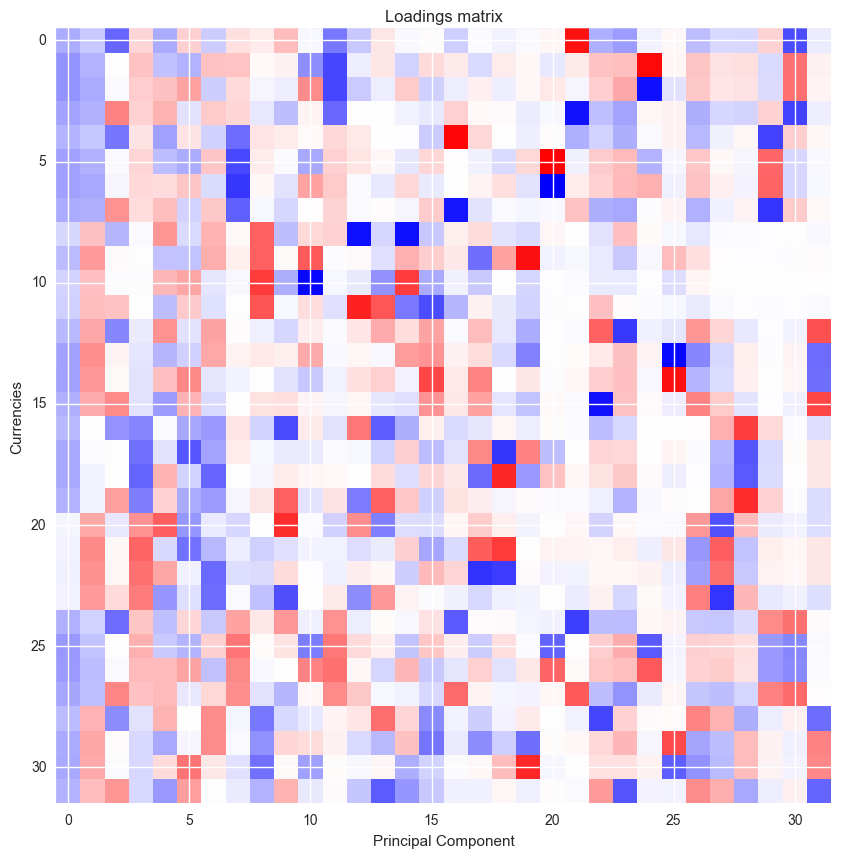

In [5]:
visualization_pca.plot_components_image(components)

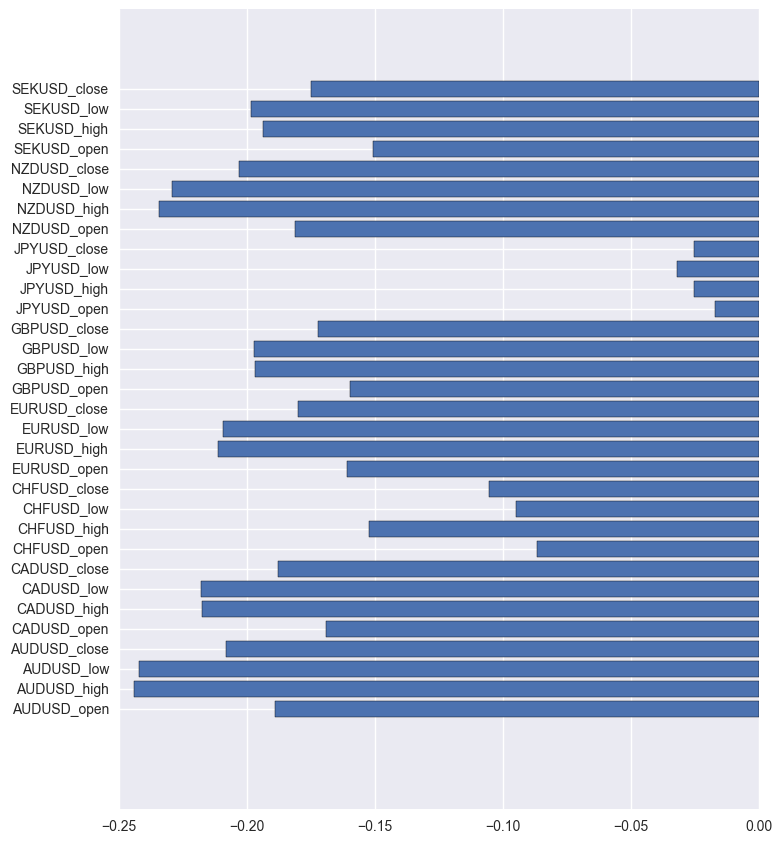

In [6]:
visualization_pca.plot_component(components, columns, component_to_plot=0)

Now let's zero out the components we are not interested in. This will enforce a sparse representation of the data.

In [5]:
components[:, n_components:] = components[:, n_components:] * 0

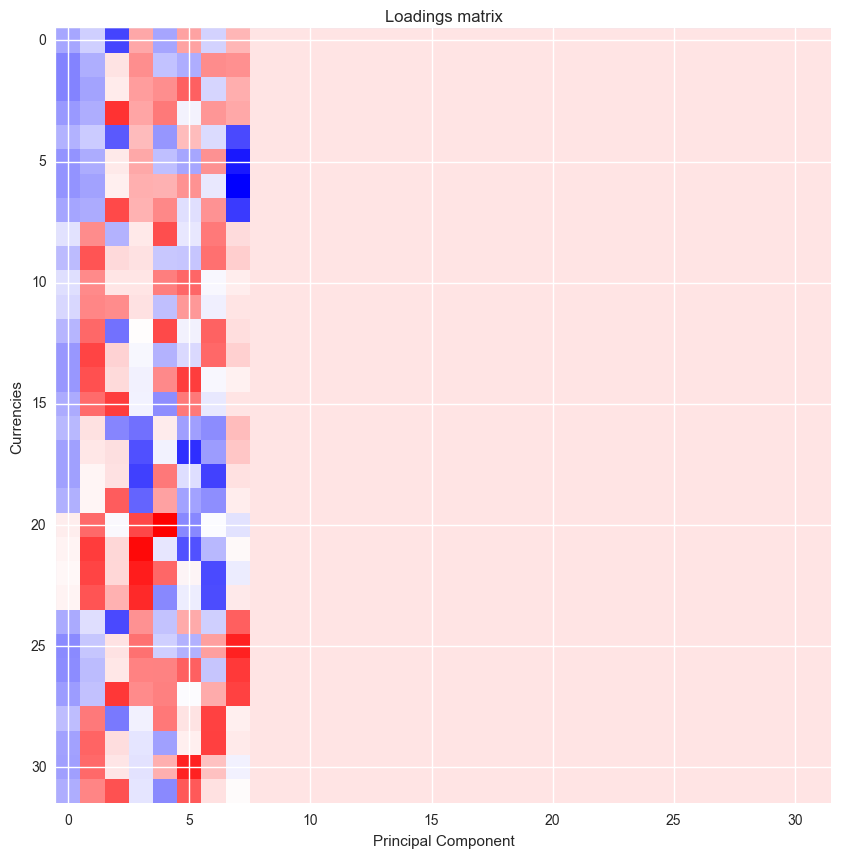

In [8]:
visualization_pca.plot_components_image(components)

A simple dot-product (with careful handling of the mean), permits us to project our initial data into the space spanned by the first 8 components. This transformation is simply a linear operation.

In [6]:
df_train_encoded = np.dot(df_train - pca.mean_, components)
df_test_encoded = np.dot(df_test - pca.mean_, components)

It's usually interesting to look at the first few scores. In finance, PCA is very often used to describe movements in rate curves, or equity volatility surface changes. In these cases, PCA naturally finds that the first score describe moves in overall level, the second score exhibit moves in skew (i.e. pentification), while the last score is related to convexification (traded using butterflies).

When used on returns more generally, it can be efficiently used to recover the market factor, through the scores of the first PC. The subsequent PCs can be used to visualize the different sectors - PCA naturally clusters data - as if the sames currencies in the group tend to have joint movements, orthogonal to the market, they would constitute additional axes of variance. Lastly, the last PCs tend to be either moves intrinsic to unique currencies, or overall noise.

Let's look at the scores for the first three components on the train set.

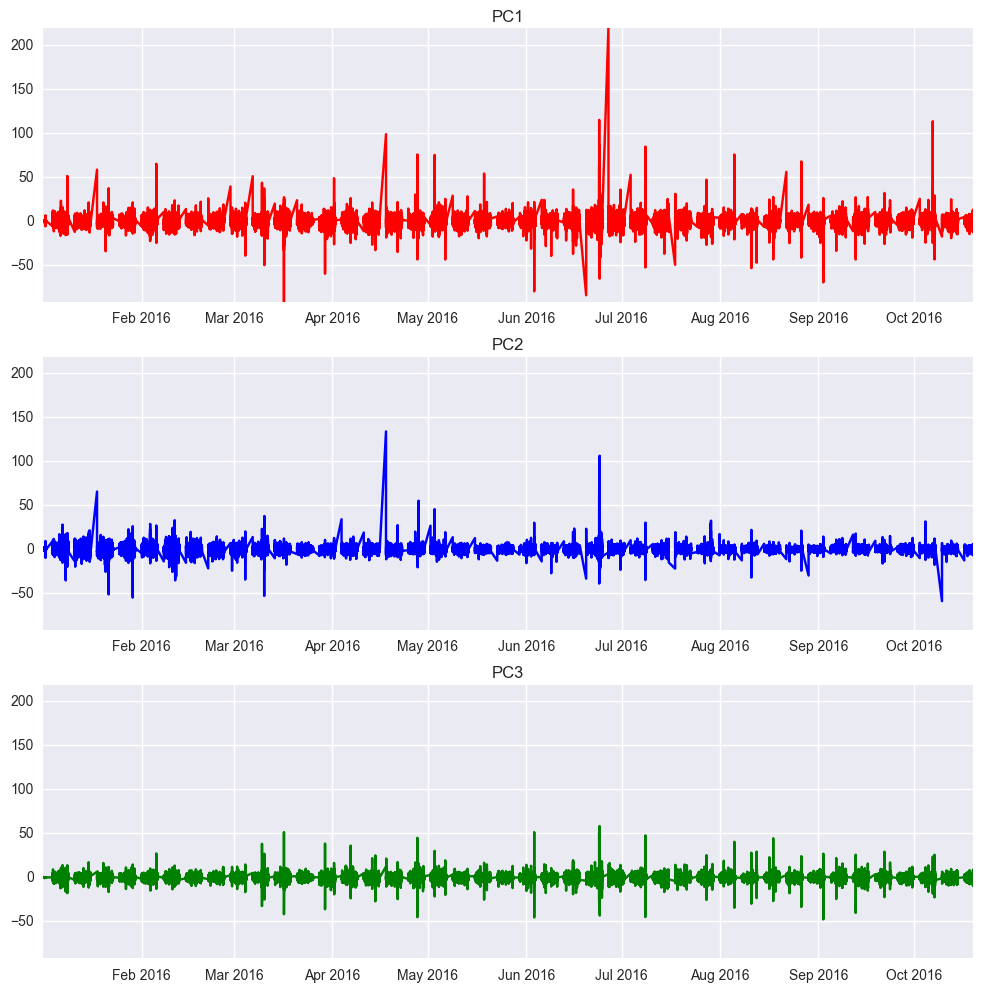

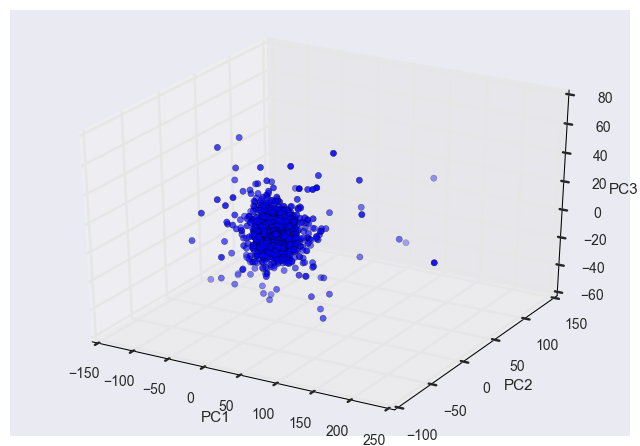

In [10]:
visualization_pca.plot_first_pcs(df_train, df_train_encoded, plot_3d=True)

As per our intuition, the first factor contains the most overall variance, and also most of the big crashes.

Finally, the data can be easily decoded, through the inverse projection of the encoded data. This step is going to be lossy, i.e. some data is lost. We then display the reconstruction errors.

In [7]:
df_train_decoded = df_train.copy()
df_test_decoded = df_test.copy()
df_train_decoded[columns] = np.dot(df_train_encoded, components.T) + pca.mean_
df_test_decoded[columns] = np.dot(df_test_encoded, components.T) + pca.mean_

In [8]:
results = utilities_autoencoder.get_errors(df_train, df_train_decoded, df_test, df_test_decoded, columns)
results

,RMSE_train,RMSE_test
AUDUSD_close,0.498601,0.442521
AUDUSD_high,0.550512,0.504793
AUDUSD_low,0.559133,0.506589
AUDUSD_open,0.498499,0.455536
CADUSD_close,0.486797,0.411037
CADUSD_high,0.472663,0.409154
CADUSD_low,0.477360,0.414858
CADUSD_open,0.506551,0.429253
CHFUSD_close,0.788213,0.973629
CHFUSD_high,0.712651,0.690295


In [9]:
results.mean(axis=0)

RMSE_train    0.555050
RMSE_test     0.529253
dtype: float64

Because by definition RMSE has the same unit as our dependant variable, and because our data have been scaled to have a standard deviation of 1, we can see that we managed to reconstruct the time series quite well. Because a picture is worth a thousand words (or numbers), we pick a currency (GBPUSD_close) and plot the series along with the reconstructed one:

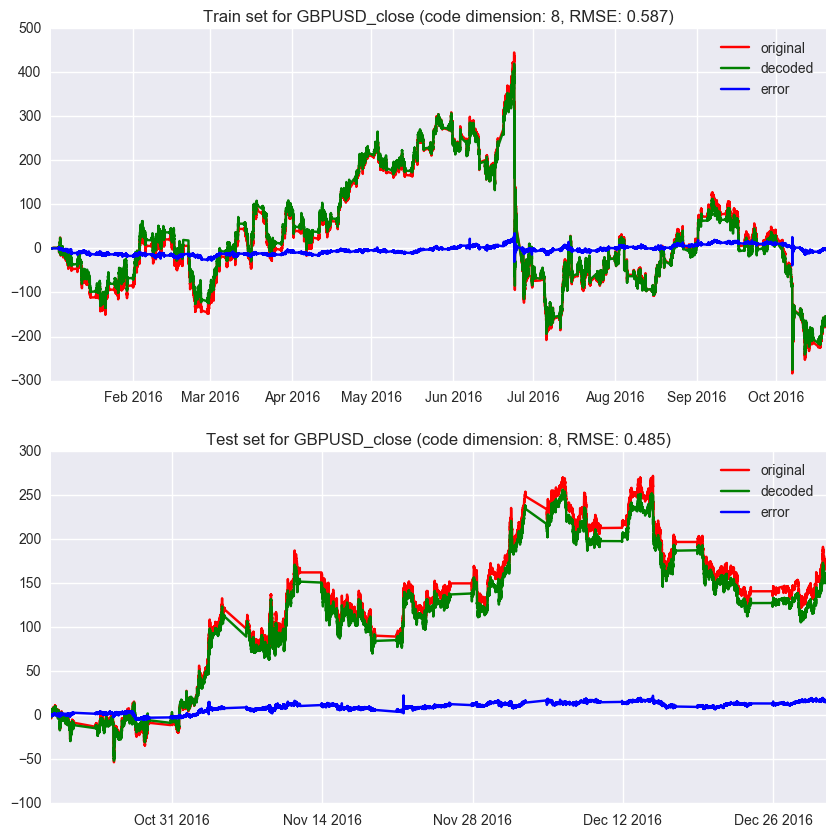

In [9]:
utilities_autoencoder.plot_decoded_data(df_train, df_train_decoded, df_test, df_test_decoded, columns, n_components, currency)

It is easy to argue that the data lost only consists of noise. Now looking at CHFUSD_close, the pair with the worst error, the situation is more stark:

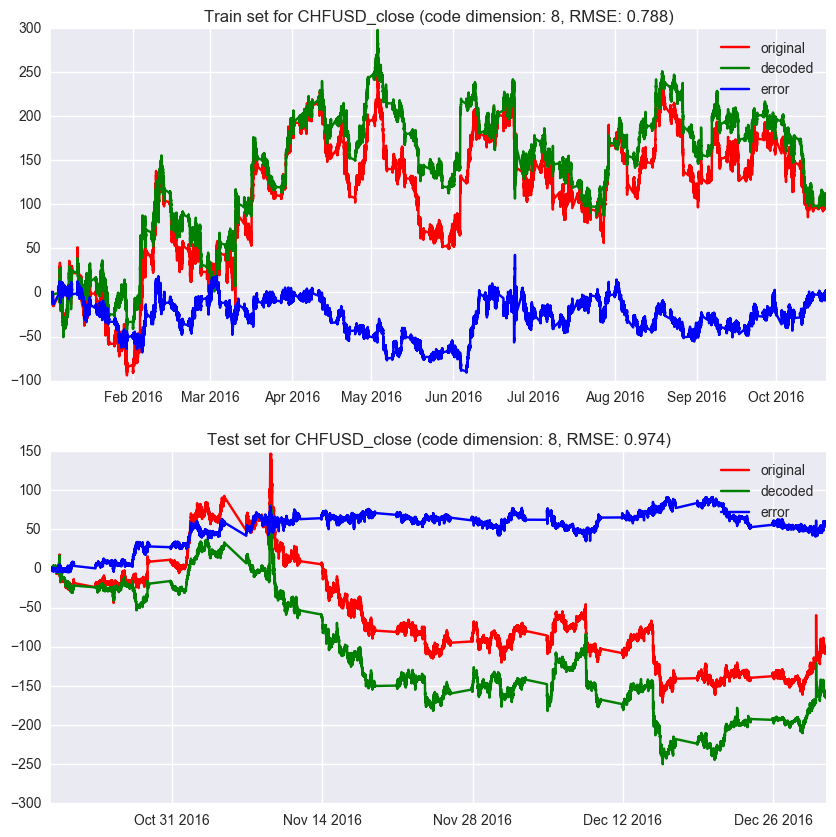

In [10]:
utilities_autoencoder.plot_decoded_data(df_train, df_train_decoded, df_test, df_test_decoded, columns, n_components, 'CHFUSD_close')

Appreciable short-lived trending periods, as well as jumps, have been lost. The gravity of this depends on the way the series would be used, and the frequency of the strategies that would be running. For very low frequency strategies, this deterioration may be acceptable. For shorter frequency, it may very well have introduced too much bias.

Let us look at an aggregated view of the reconstruction error in the train and test set, as a function of the code dimension.

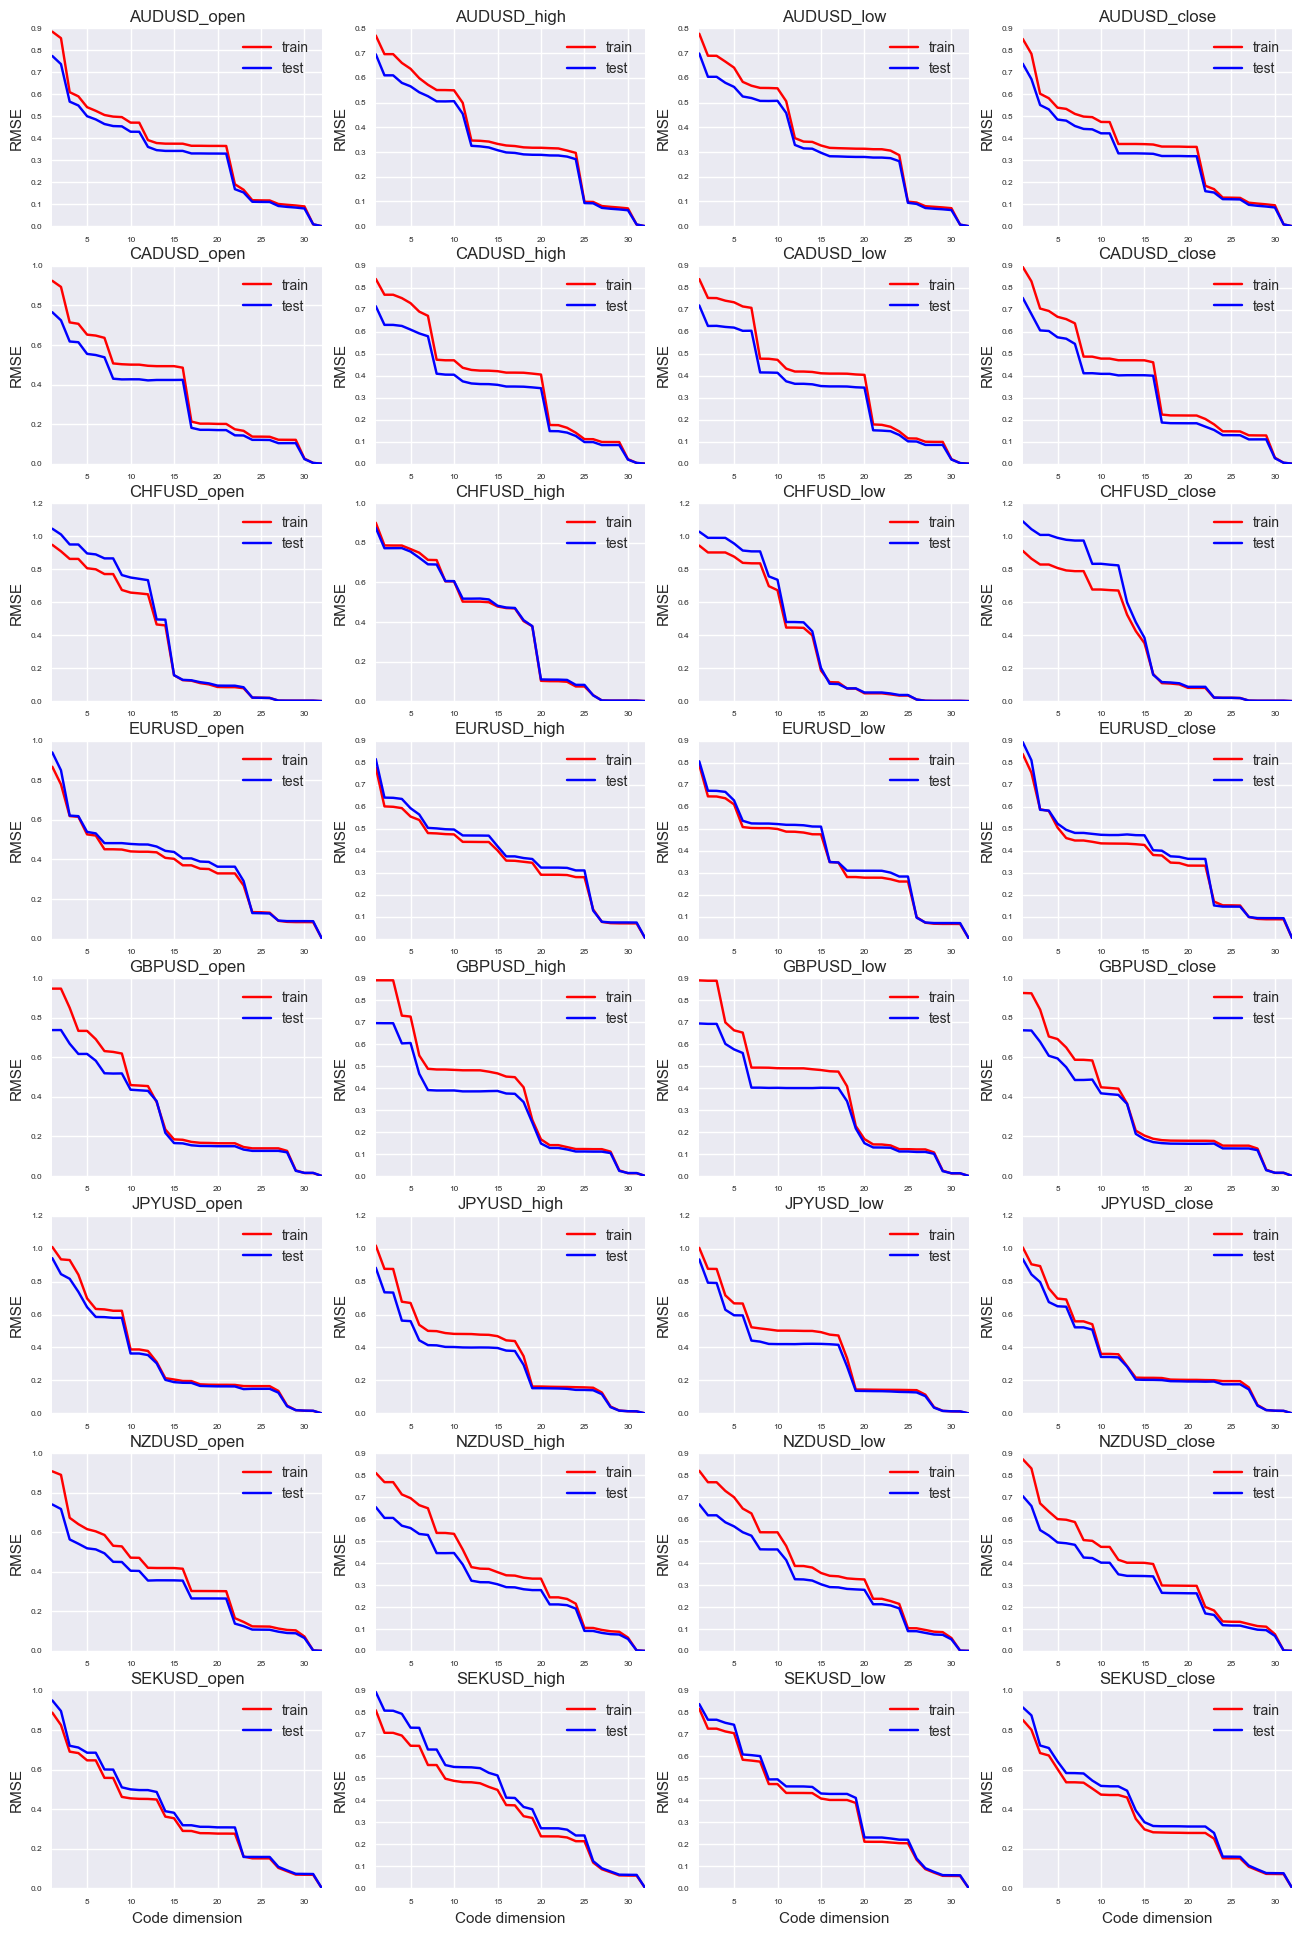

In [2]:
results_per_currency = utilities_pca.autoencoding_pca_many(df_train, df_test, columns)
visualization_pca.plot_all_columns(results_per_currency, columns)

The first observation is that PCA has errors monotonically decreasing as a function of the code dimension (as it should).

The second observation is that the errors mostly decay linearly with the code dimension, with some abrupt jumps down as certain PCs are added. These PCs may contain some idiosyncratic information about the given series.

Similarly to PCA, ICA (Independant Component Analysis), is an iterative algorithm to finds the direction for the weight vector $w$ that maximizes a measure of non-Gaussianity of the projection $w^TX$. The subsequent vectors still aim to maximize the non-gaussianity, under the constraint of orthogonality to the previous weight vectors. To measure non-Gaussianity, FastICA (the algorithm implemented in sklearn) relies either on a nonquadratic nonlinearity function, or sometimes tries to maximize the Kurtosis. The algorithm can be summarily described as the following: 

Algorithm:

for $p$ in $1$ to $C$:

$\ \ \ \ w_p =$ Random vector of length $N$

$\ \ \ $ while $w_p$ changes:

$\ \ \ \ \ \ \ \ w_p = \frac{1}{M} Xg(w_p^T X)^T-\frac{1}{M}g'(w_p^TX)1w_p$

$\ \ \ \ \ \ \ \ w_p = w_p -\sum _{j=1}^{p-1}w_p^Tw_j w_j$

$\ \ \ \ \ \ \ \ w_p = \frac{w_p}{\|w_p\|}$

Output:

$S=W^TX$

Where $W \in \mathbb {R}^{n\times C}$ is the un-mixing matrix where each column projects $X$ onto independent component. Therefore it is also a linear method.

Because it is ready to use in sklearn and so close to PCA, we run a quick test to see if we can achieve a better precision than with PCA (because non-gaussianity is an important feature of financial time series, so the method is attractive).

In [3]:
ica = sklearn.decomposition.FastICA(n_components=len(columns), whiten=False)
ica.fit(df_train)

df_train_encoded = ica.transform(df_train)
df_test_encoded = ica.transform(df_test)

df_train_encoded[:, n_components:] = df_train_encoded[:, n_components:] * 0
df_test_encoded[:, n_components:] = df_test_encoded[:, n_components:] * 0

df_train_decoded = df_train.copy()
df_test_decoded = df_test.copy()
df_train_decoded[columns] = ica.inverse_transform(df_train_encoded)
df_test_decoded[columns] = ica.inverse_transform(df_test_encoded)

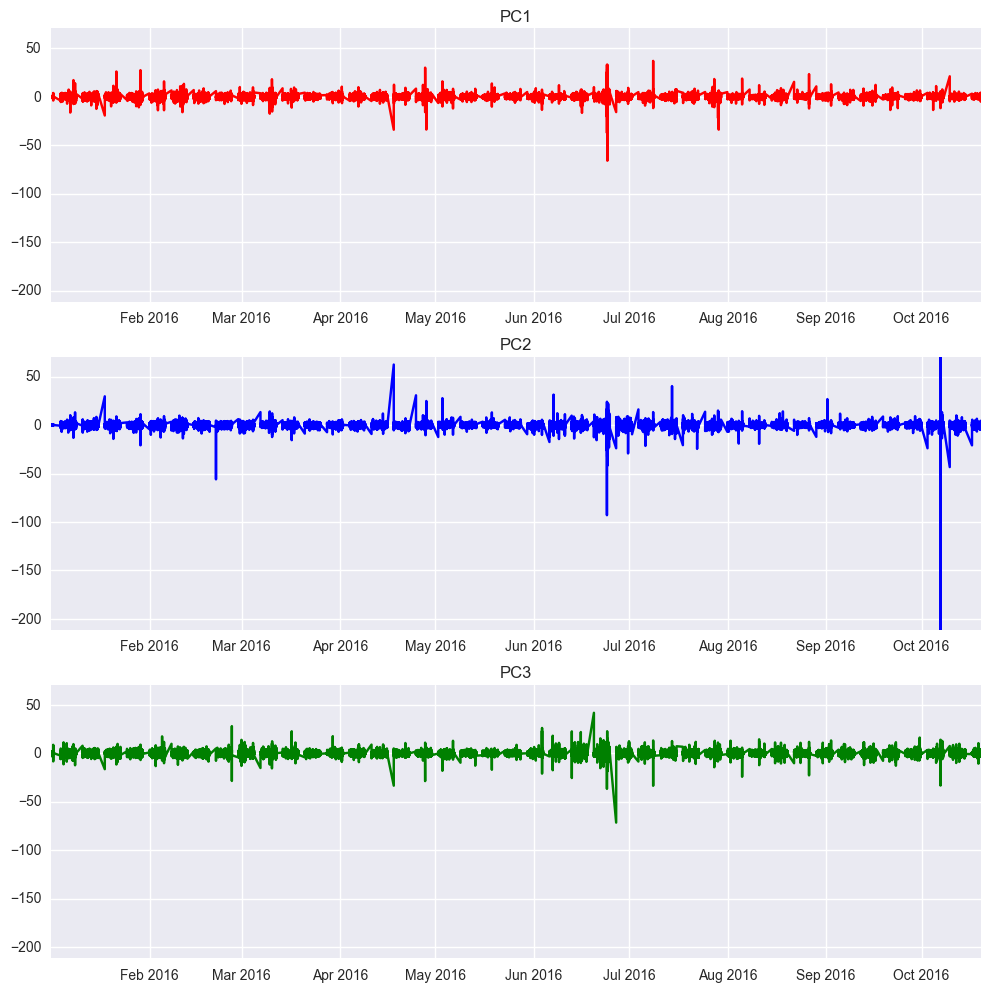

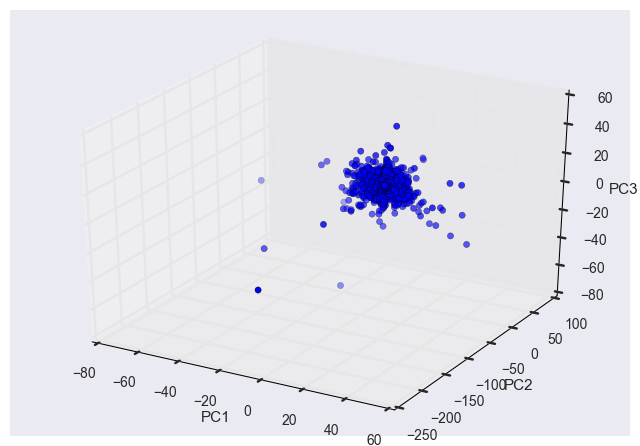

In [5]:
visualization_pca.plot_first_pcs(df_train, df_train_encoded, plot_3d=True)

In [7]:
results = utilities_autoencoder.get_errors(df_train, df_train_decoded, df_test, df_test_decoded, columns)
results

,RMSE_train,RMSE_test
AUDUSD_close,0.939115,0.796731
AUDUSD_high,0.883262,0.736504
AUDUSD_low,0.852906,0.738141
AUDUSD_open,0.845741,0.723109
CADUSD_close,0.932069,0.771980
CADUSD_high,0.778283,0.665094
CADUSD_low,0.881919,0.722741
CADUSD_open,0.853185,0.682622
CHFUSD_close,0.904767,1.076462
CHFUSD_high,0.924879,0.925187


In [8]:
results.mean(axis=0)

RMSE_train    0.870691
RMSE_test     0.800834
dtype: float64

The result is much worse than with PCA (where we achieved an average of roughly 0.5 RMSE using 8 components). Let us look at one example of time series, and at the aggregated view to understand what happens.

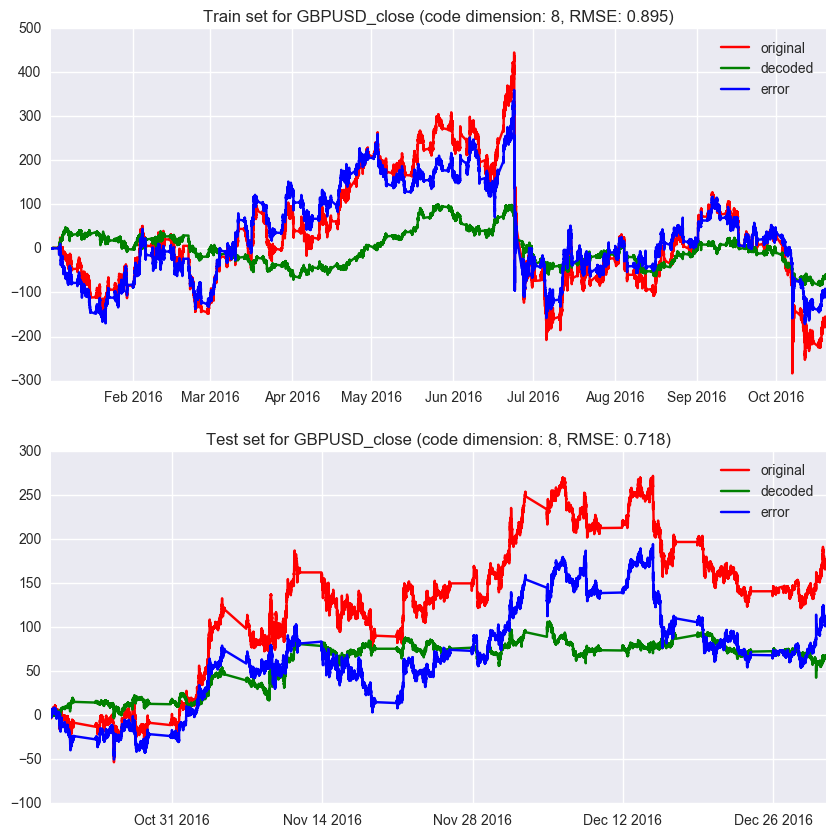

In [9]:
utilities_autoencoder.plot_decoded_data(df_train, df_train_decoded, df_test, df_test_decoded, columns, n_components, currency)

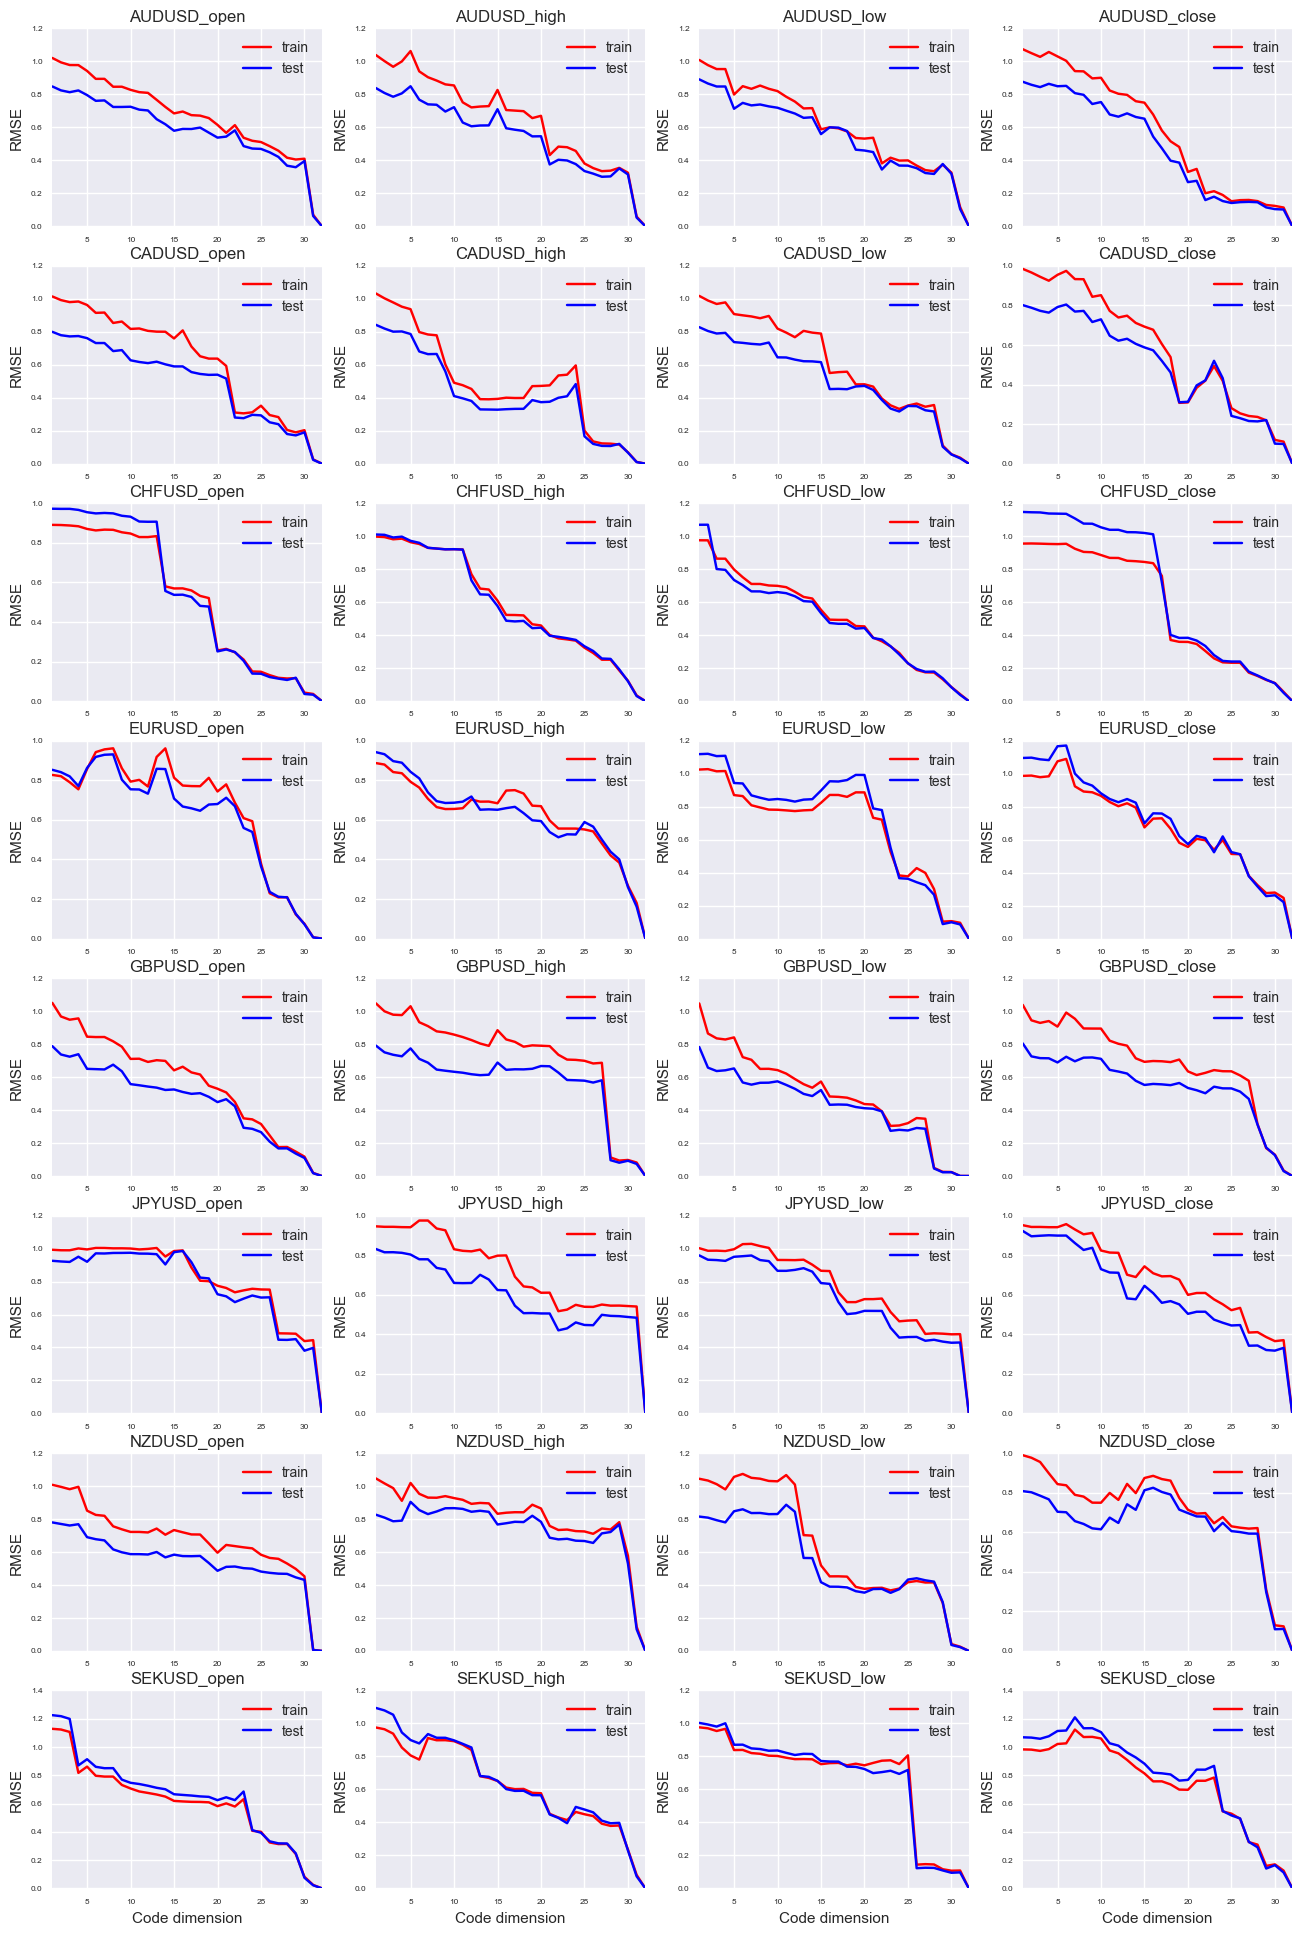

In [2]:
results_per_currency = utilities_pca.autoencoding_ica_many(df_train, df_test, columns)
visualization_pca.plot_all_columns(results_per_currency, columns)

- Most currencies exhibit a higher starting point (all the PCA RMSEs started below 1 for a code dimension of one). ICA often starts above 1.

- The decrease in test and train data, being similar, usually decrease slowly, and jump down when some particular component is added (often towards the end).

- The error is not stricly monotonic decreasing with code dimension! This is not a desirable property to have at all.

- Overall this method looks mediocre.

This concludes the summary of the PCA for auto-encoding, which will be one of our benchmarks.